# Hello World

We need to initialize our environment to use the Lucata toolchain. This toolchain allows you to compile Cilk code with x86, the Lucata simulator, and for hardware execution. Note that this notebook should load the toolchain using the included .env file, so this is just if you wanted to compile code on the command line.


In [1]:
%%bash
. /tools/emu/pathfinder-sw/set-lucata-env.sh
which emu-cc

Lucata tools are added to current path from /tools/emu/pathfinder-sw/21.06
/tools/emu/pathfinder-sw/21.06/bin/emu-cc


## Naive Hello World

Here is a "Hello, world" example to start showing aspects of writing for the Emu. However, your first question might be related to the use of the mw_malloc1dlong array with a distributed system.

Where does `ptr` itself live? Does computing `ptr[k]` cause a migration?

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

// These are Emu-specific.
#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

long * ptr;
char * str_out;

int main (void)
{
     // long is the reliable word length, 64-bits.
     const long n = strlen (str) + 1;

     ptr = mw_malloc1dlong (n); // striped across the nodelets
     str_out = malloc (n * sizeof (char))); // entirely on the first nodelet

     starttiming(); // For the simulator.  Start gathering stats here.

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          str_out[k] = (char)ptr[k]; // Migration and remote write...

     printf("%s\n", str_out);  // Migration back
}
```



We'll test compiling this example to show the syntax and then move on to a more optimized example. Note that the .mwx output can be used for simulation and execution on the Pathfinder system.

In [2]:
%%bash
. /tools/emu/tutorial-env.sh
cd ${USER_NOTEBOOK_CODE}/01-hello-world
emu-cc -o hello-world-naive.mwx hello-world-naive.c
ls *.mwx

hello-world-naive.mwx


## Hello World

With the Lucata architecture, we often want to avoid spurious migrations by replicating data across nodes so that each node has a copy of the relevant data it needs. This improved sample in `hello-world/hello-world.c`, demonstrates the usage of the `replicated` type:

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

// These are Emu-specific.
#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     // long is the reliable word length, 64-bits.
     const long n = strlen (str) + 1;

     /* Allocating a copy on each nodelet reduces migrations in theory.
        In *this* case, the pointers stay in registers and do not trigger migration.
        But that's up to compiler register allocation... */
     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming(); // For the simulator.  Start gathering stats here.

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          str_out[k] = (char)ptr[k]; // Migration and remote write

     printf("%s\n", str_out);  // Migration back
}
```
Let's compile and simulate this one. 

In [3]:
%%bash
. /tools/emu/tutorial-env.sh
emu-cc -o hello-world.mwx hello-world.c
ls *.mwx

hello-world.mwx
hello-world-naive.mwx


Note that we are using the "capture_timing_queues" and "output_instruction_count" flags to generate some added data from the simulator. These generate tqd and uis files respectively.

In [4]:
%%bash
. /tools/emu/tutorial-env.sh
emusim.x --capture_timing_queues --output_instruction_count -- hello-world.mwx

Start untimed simulation with local date and time= Sun Jul 18 02:17:13 2021

End untimed simulation with local date and time= Sun Jul 18 02:17:13 2021

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Jul 18 02:17:13 2021

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.



        SystemC 2.3.3-Accellera --- Jun 22 2021 17:09:43
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED


In [5]:
!ls hello-world.*

hello-world.c	 hello-world.ipynb  hello-world.mwx  hello-world.uis
hello-world.cdc  hello-world.mps    hello-world.tqd  hello-world.vsf


We now have several different output files. These are detailed in Ch. 7.6 of the Programming Guide and are as follows:
* hello-world.mwx - Lucata executable
* hello-world.cdc - Configuration data output file; includes system information and wall-clock time
* hello-world.mps - Memory map output; shows memory operation types and thread enqueuing
* hello-world.tqd - Timed activity tracing; includes live threads, thread activity counts, and requests
* hello-world.uis - Instruction count statistics; shows the number of instructions per function in the application and number of migrations
* hello-world.vsf - Verbose statistics information; advanced counter statistics for debugging bottlenecks

These files can be used with plotting tools to provide detailed output on the simulation of the application.

In [6]:
%%bash
. /tools/emu/tutorial-env.sh
make_tqd_plots.py hello-world.tqd

Generating hello-world.Live_Threads.png
Generating hello-world.Thread_Activity.png
Generating hello-world.MSP_Activity.png


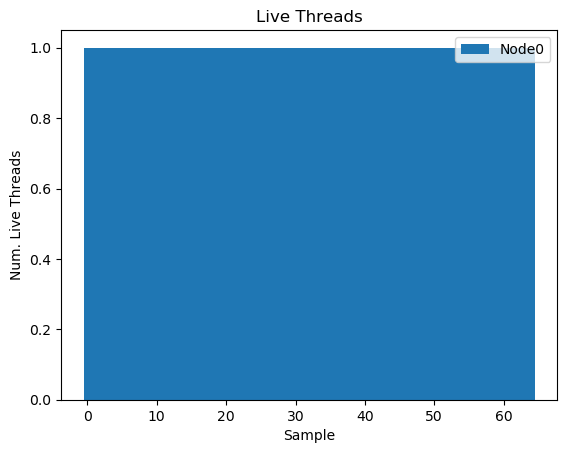

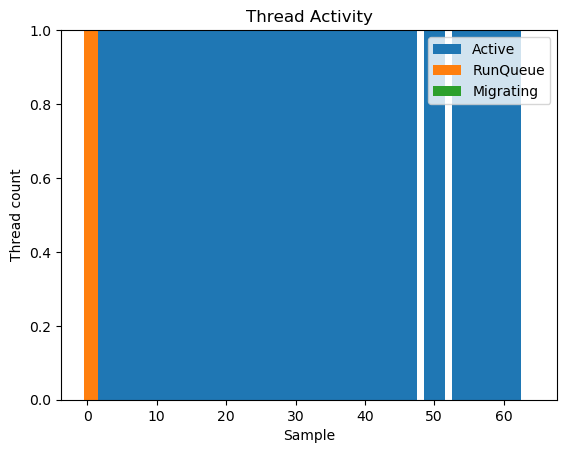

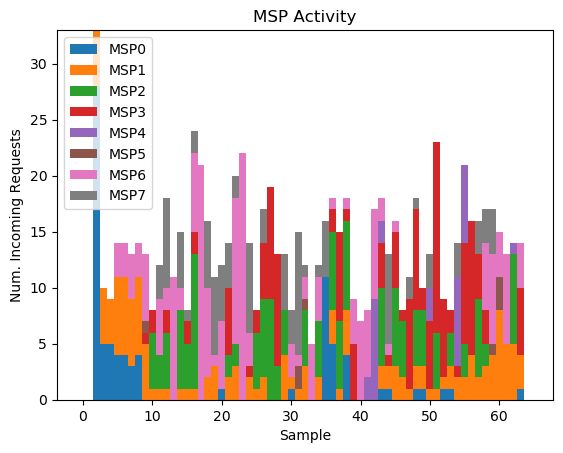

In [7]:
from IPython.display import Image, display
display(Image(filename="hello-world.Live_Threads.png"))
display(Image(filename="hello-world.Thread_Activity.png"))
display(Image(filename="hello-world.MSP_Activity.png"))

In [8]:
%%bash
. /tools/emu/tutorial-env.sh
make_map_plots.py hello-world.mps

Generating hello-world.Thread_Enqueue_Map.png
Generating hello-world.Memory_Read_Map.png
Generating hello-world.Memory_Write_Map.png
Generating hello-world.Atomic_Transaction_Map.png
Generating hello-world.Remote_Transaction_Map.png


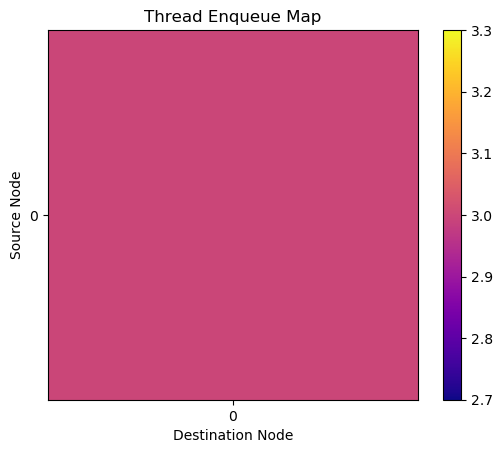

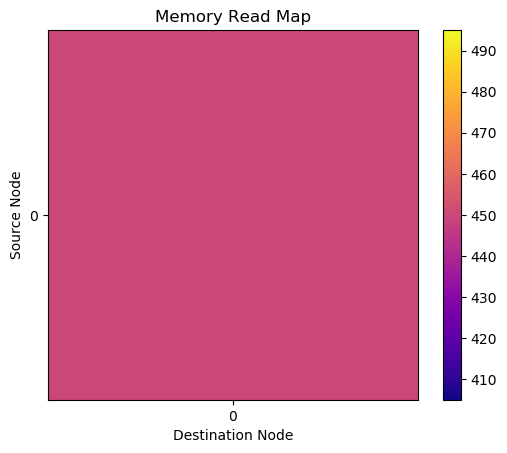

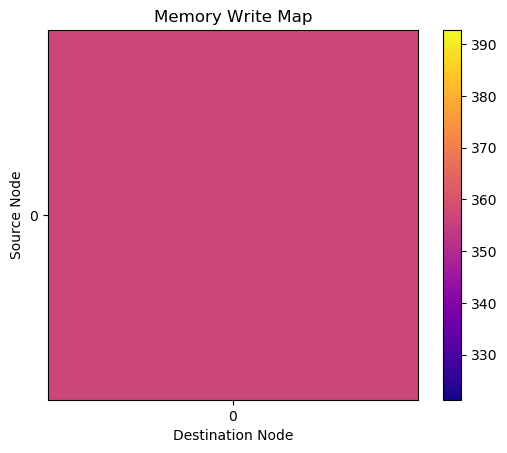

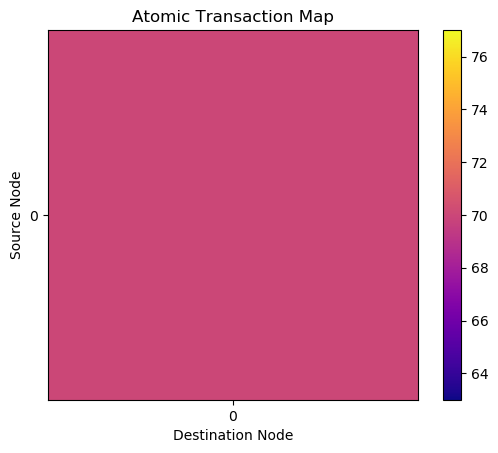

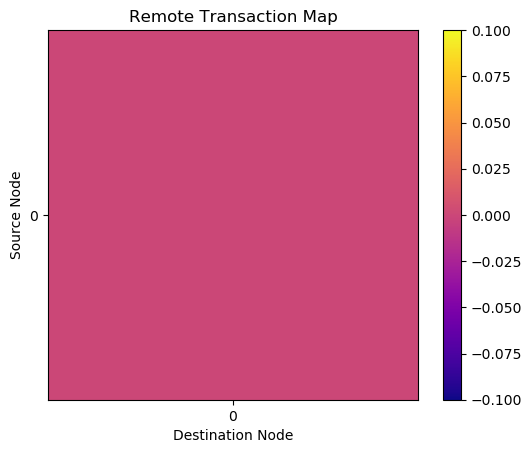

In [9]:
display(Image(filename="hello-world.Thread_Enqueue_Map.png"))
display(Image(filename="hello-world.Memory_Read_Map.png"))
display(Image(filename="hello-world.Memory_Write_Map.png"))
display(Image(filename="hello-world.Atomic_Transaction_Map.png"))
display(Image(filename="hello-world.Remote_Transaction_Map.png"))

In [10]:
%%bash
. /tools/emu/tutorial-env.sh
make_uis_plots.py hello-world.uis

Generating hello-world_total_instructions.png
Generating hello-world_total_migrations.png


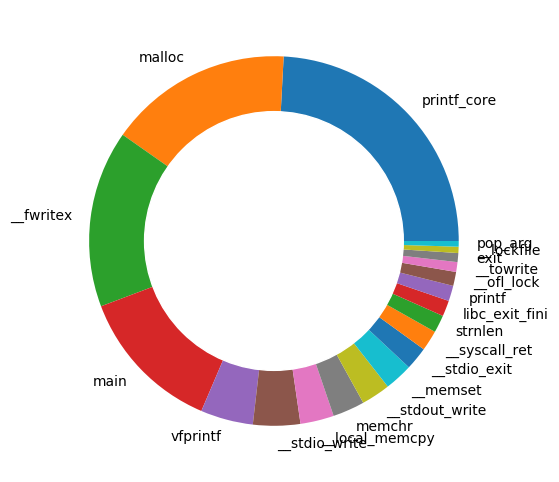

In [11]:
display(Image(filename="hello-world_total_instructions.png"))

## Hello World Spawn Example

That example kept one thread alive and migrating between nodelets.  This one, hello-world-spawn.c, uses Cilk's thread spawning intrinsic:

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming();

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          cilk_spawn copy_ptr (&str_out[k], &ptr[k]);

     printf("%s\n", str_out);  // Migration back
}
```

In [12]:
%%bash
. /tools/emu/tutorial-env.sh
emu-cc -o hello-world-spawn.mwx hello-world-spawn.c
emusim.x --capture_timing_queues --output_instruction_count -- hello-world-spawn.mwx
ls hello-world-spawn*
make_tqd_plots.py hello-world-spawn.tqd
make_map_plots.py hello-world-spawn.mps
make_uis_plots.py hello-world-spawn.uis

Start untimed simulation with local date and time= Sun Jul 18 02:17:31 2021

End untimed simulation with local date and time= Sun Jul 18 02:17:31 2021

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Jul 18 02:17:31 2021

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.
hello-world-spawn-at.c
hello-world-spawn-at_profile.csv
hello-world-spawn-at.uis
hello-world-spawn.c
hello-world-spawn.cdc
hello-world-spawn.mps
hello-world-spawn.mwx
hello-world-spawn_profile.csv
hello-world-spawn.tqd
hello-world-spawn.uis
hello-world-spawn.vsf
Generating hello-world-spawn.Live_Threads.png
Generating hello-world-spawn.Thread_Activity.png
Generating hello-world-spawn.MSP_Activity.png
Generating hello-world-spawn.Thread_Enqueue_Map.png
Generating hello-world-spawn.Memory_Read_Map.png
Generating hello-world-spawn.Memory_Write_Map.png
Generating hello-world-spawn.Atomic_Transaction_Map.png
Generating hello-world-spawn.Remote_Transaction_Map.png
Gener


        SystemC 2.3.3-Accellera --- Jun 22 2021 17:09:43
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED


Then we can compare the output of the normal Hello World and the Spawn Hello World for the statistics that are different.

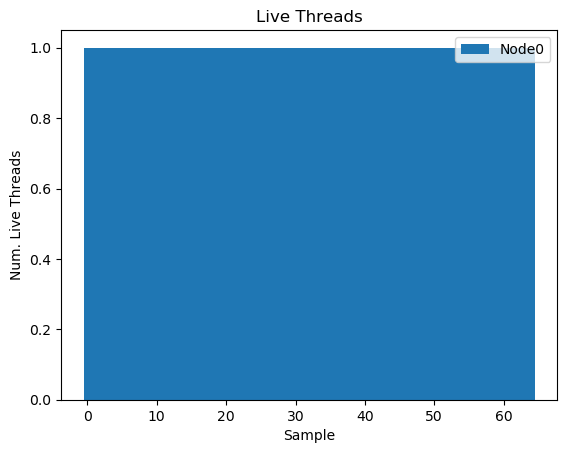

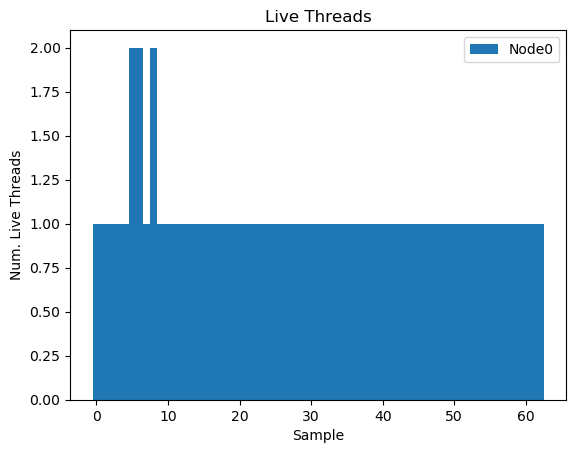

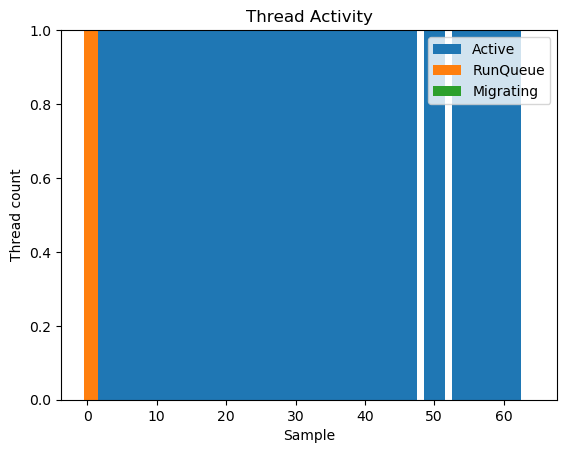

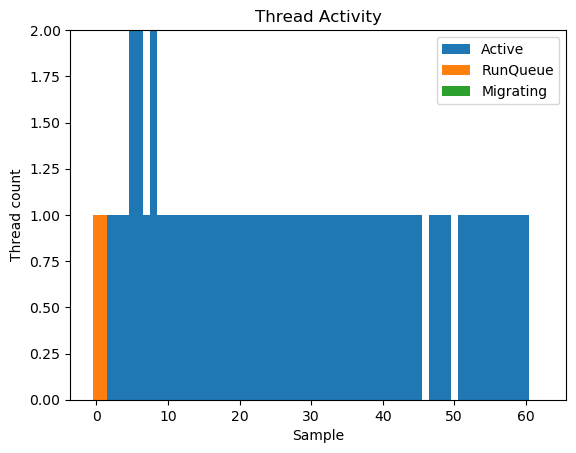

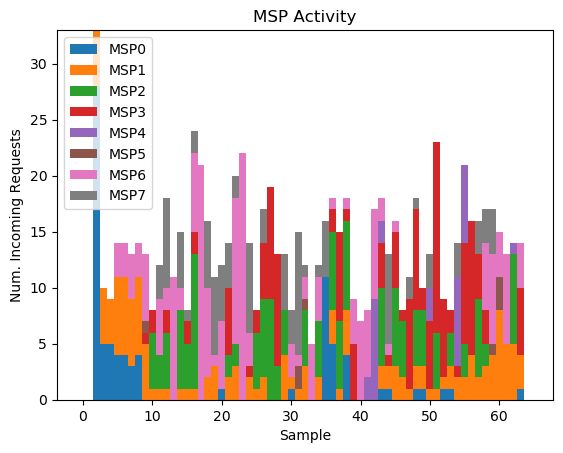

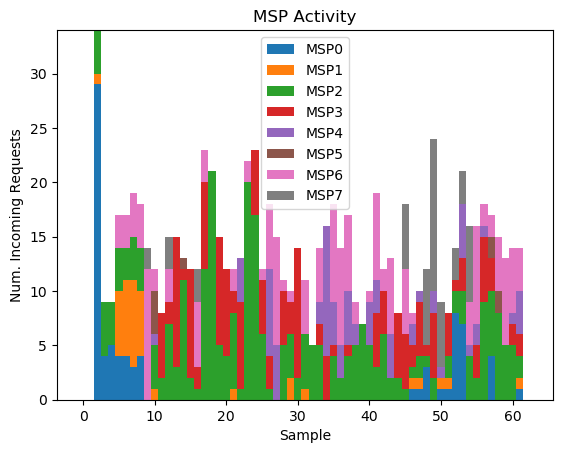

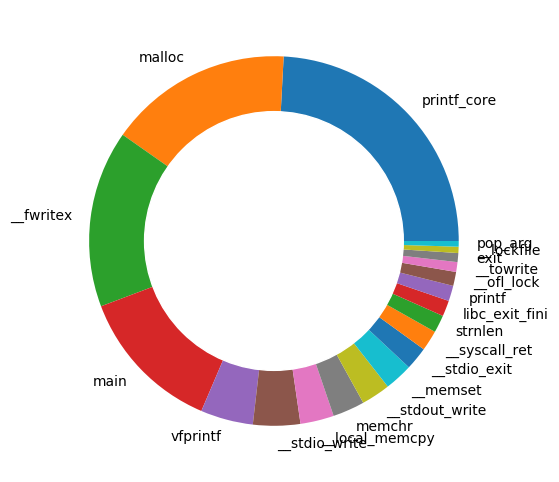

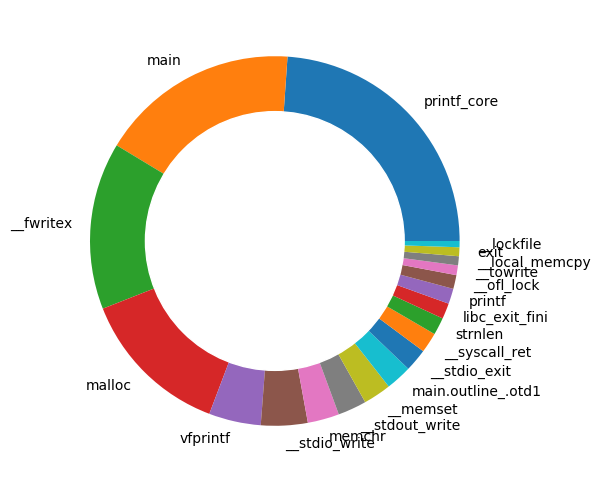

In [13]:
display(Image(filename="hello-world.Live_Threads.png"))
display(Image(filename="hello-world-spawn.Live_Threads.png"))
display(Image(filename="hello-world.Thread_Activity.png"))
display(Image(filename="hello-world-spawn.Thread_Activity.png"))
display(Image(filename="hello-world.MSP_Activity.png"))
display(Image(filename="hello-world-spawn.MSP_Activity.png"))
display(Image(filename="hello-world_total_instructions.png"))
display(Image(filename="hello-world-spawn_total_instructions.png"))

## Advanced Implementation - Spawn At

This example just shows one additional variation of using a `cilk_spawn_at` call to spawn threads at a remote node

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming();

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k) {
          cilk_spawn_at(&ptr[k]) copy_ptr (&str_out[k], &ptr[k]);
     }

     printf("%s\n", str_out);  // Migration back
}
```

In [14]:
%%bash
. /tools/emu/tutorial-env.sh
emu-cc -o hello-world-spawn-at.mwx hello-world-spawn-at.c
emusim.x --capture_timing_queues --output_instruction_count -- hello-world-spawn-at.mwx
ls hello-world-spawn-at*
make_map_plots.py hello-world-spawn-at.mps
make_tqd_plots.py hello-world-spawn-at.tqd
make_uis_plots.py hello-world-spawn-at.uis

Start untimed simulation with local date and time= Sun Jul 18 02:17:48 2021

End untimed simulation with local date and time= Sun Jul 18 02:17:48 2021

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Jul 18 02:17:48 2021

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.
hello-world-spawn-at.c
hello-world-spawn-at.cdc
hello-world-spawn-at.mps
hello-world-spawn-at.mwx
hello-world-spawn-at_profile.csv
hello-world-spawn-at.tqd
hello-world-spawn-at.uis
hello-world-spawn-at.vsf
Generating hello-world-spawn-at.Thread_Enqueue_Map.png
Generating hello-world-spawn-at.Memory_Read_Map.png
Generating hello-world-spawn-at.Memory_Write_Map.png
Generating hello-world-spawn-at.Atomic_Transaction_Map.png
Generating hello-world-spawn-at.Remote_Transaction_Map.png
Generating hello-world-spawn-at.Live_Threads.png
Generating hello-world-spawn-at.Thread_Activity.png
Generating hello-world-spawn-at.MSP_Activity.png
Generating hello-world-spawn-at_total_


        SystemC 2.3.3-Accellera --- Jun 22 2021 17:09:43
        Copyright (c) 1996-2018 by all Contributors,
        ALL RIGHTS RESERVED


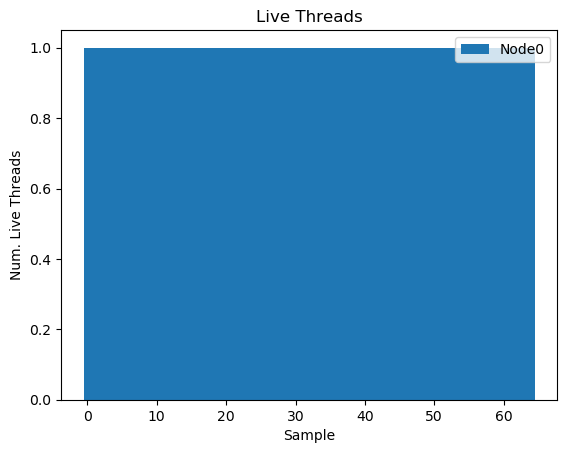

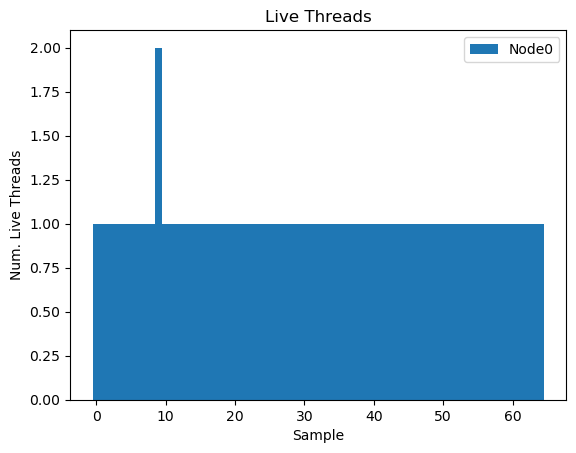

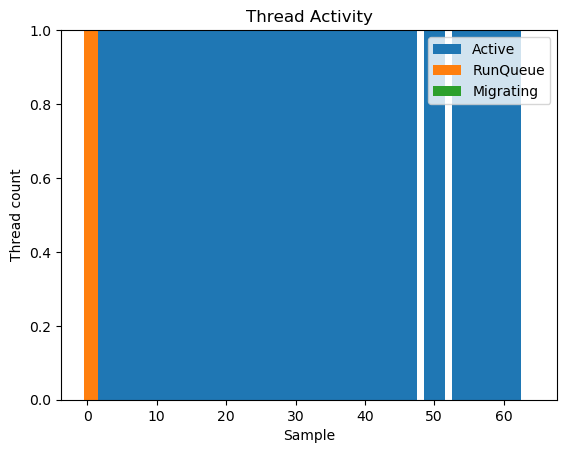

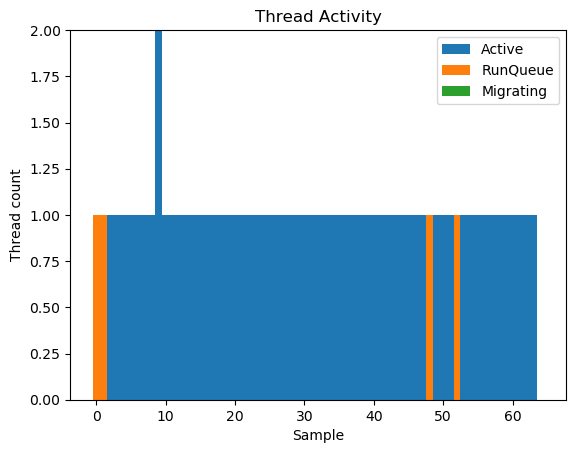

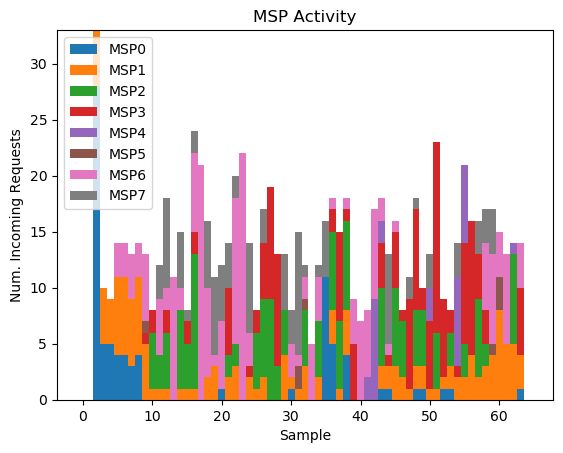

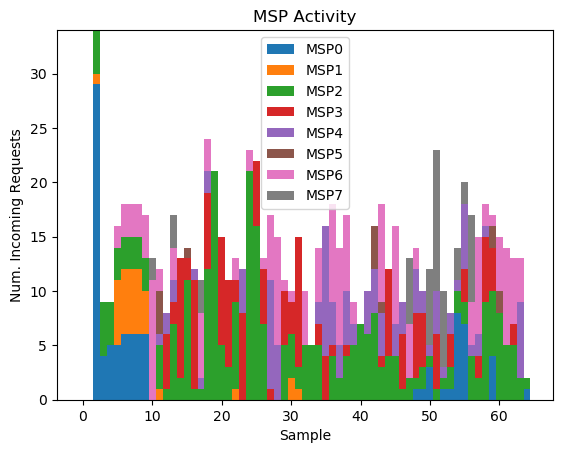

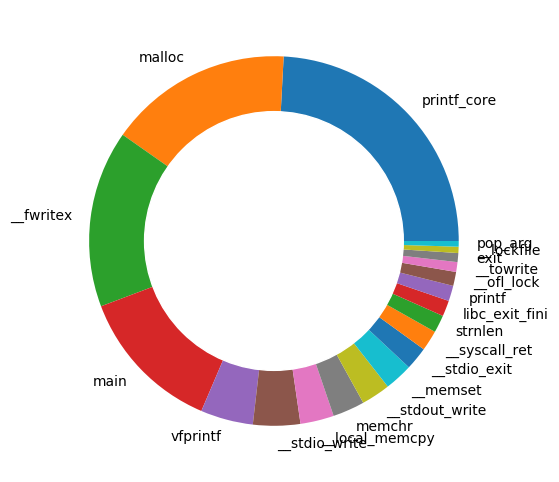

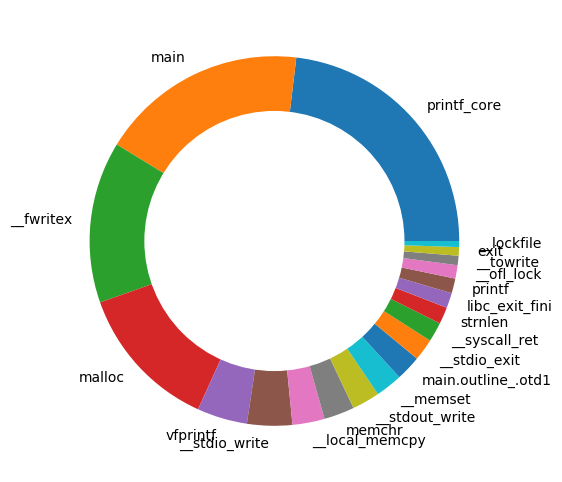

In [15]:
display(Image(filename="hello-world.Live_Threads.png"))
display(Image(filename="hello-world-spawn-at.Live_Threads.png"))
display(Image(filename="hello-world.Thread_Activity.png"))
display(Image(filename="hello-world-spawn-at.Thread_Activity.png"))
display(Image(filename="hello-world.MSP_Activity.png"))
display(Image(filename="hello-world-spawn-at.MSP_Activity.png"))
display(Image(filename="hello-world_total_instructions.png"))
display(Image(filename="hello-world-spawn-at_total_instructions.png"))